In [1]:
import jax
from jax import numpy as jnp
from jax.config import config; config.update("jax_enable_x64", True)

import matplotlib
import matplotlib.pyplot as plt
import sys; sys.path.insert(1, '..')

from env.sample import Sampler
from algs.pg import stochNaturalPG
from algs.train import PG_Trainer
from env.utils import ExampleMDPs

In [2]:
GSCALE = 0.5
PLIM = 80
INIT_RAD=3

def plot_params_traj(trace,ax):
    policy = jnp.array([e['params']['policy'][0,:] for e in trace])
    grads = jnp.array([e['grads']['policy'][0,:] for e in trace])
    a1 = policy[:,0]; a2 = policy[:,1]; t = jnp.arange(a1.shape[0]);
    ax.set_xlim([-INIT_RAD,INIT_RAD]); ax.set_ylim([-INIT_RAD,INIT_RAD])

    for i,g in enumerate(grads):
        ax.arrow(x=a1[i],y=a2[i],dx=GSCALE*g[0],dy=GSCALE*g[1],head_width=0.05, head_length=0.1, fc='k', ec='k')

    ax.scatter(a1,a2,c=t,marker='.')
    

def plot_policy_traj(trace,ax,trainer):
    policy = jnp.array([trainer.pFun(e['params']['policy']) for e in trace])[:,0,:]
    a1 = policy[:,1]; t = jnp.arange(a1.shape[0]);
    ax.set_ylim([-0.1,1.1])
    ax.plot(t,a1,)

def plot_return(trace,ax):
    J = jnp.array([e['J'] for e in trace]); t = jnp.arange(J.shape[0]);
    ax.plot(t,J)

### Deterministic Bandit Example

In [20]:
mdp = ExampleMDPs.bandit1()
traces = []
for seed in range(5):
    trainer = PG_Trainer(mdp,policy_lr=1e0,beta=5e-1,max_theta=PLIM,key=jax.random.PRNGKey(seed),init_radius=INIT_RAD)
    optimizers, trace = trainer.train(20)
    traces += [trace]

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:00<00:00, 25.73it/s]


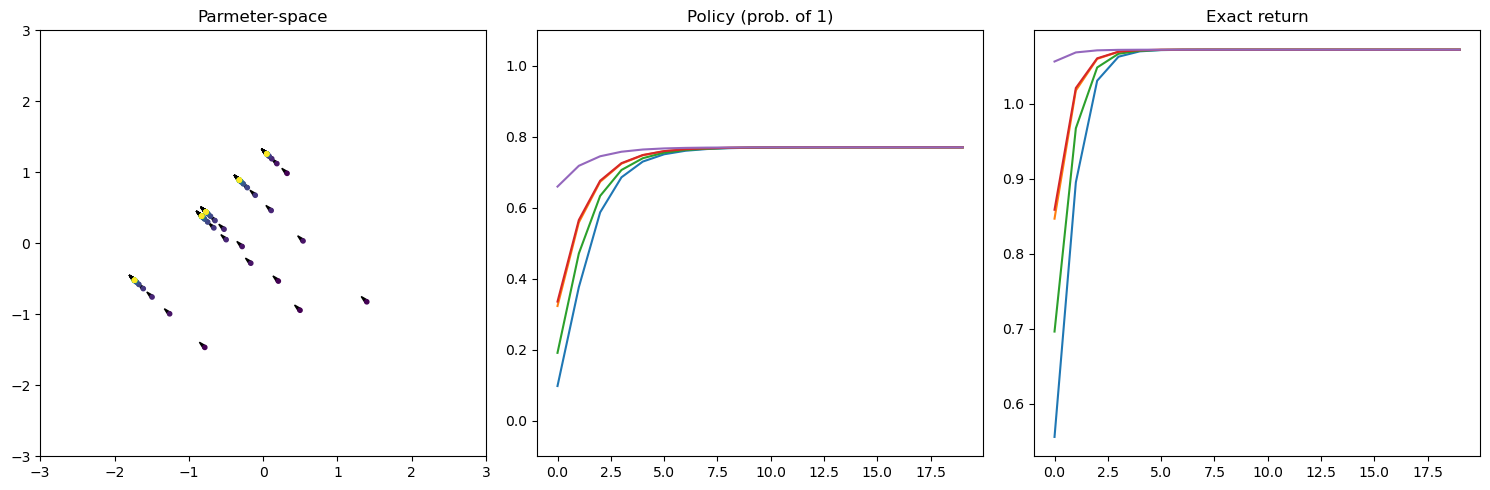

In [21]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
policyClass = plt.Circle((0, 0), PLIM, color='r',fill=False)
ax[0].add_patch(policyClass)
for trace in traces:
    plot_params_traj(trace,ax[0])
    plot_policy_traj(trace,ax[1],trainer)
    plot_return(trace,ax[2])
ax[0].set_title('Parmeter-space')
ax[1].set_title('Policy (prob. of 1)')
ax[2].set_title('Exact return')

fig.tight_layout()
plt.show()

### Stochastic Bandit Example

In [31]:
mdp = ExampleMDPs.bandit1()
plim = 80
traces = []
for seed in range(10):
    smp = Sampler(mdp,batchsize=300,horizon=50)
    trainer = PG_Trainer(mdp,policy_lr=1e-2,beta=5e-1,sampler=smp,gradients=stochNaturalPG,max_theta=plim,key=jax.random.PRNGKey(seed),init_radius=INIT_RAD)
    optimizers, trace = trainer.train(30)
    
    traces += [trace]

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:40<00:00,  1.34s/it]


In [32]:
GSCALE = 0.005
PLIM = 80
INIT_RAD=3

def plot_params_traj(trace,ax):
    policy = jnp.array([e['params']['policy'][0,:] for e in trace])
    grads = jnp.array([e['grads']['policy'][0,:] for e in trace])
    a1 = policy[:,0]; a2 = policy[:,1]; t = jnp.arange(a1.shape[0]);
    ax.set_xlim([-INIT_RAD,INIT_RAD]); ax.set_ylim([-INIT_RAD,INIT_RAD])

    for i,g in enumerate(grads):
        ax.arrow(x=a1[i],y=a2[i],dx=GSCALE*g[0],dy=GSCALE*g[1],head_width=0.05, head_length=0.1, fc='k', ec='k')

    ax.scatter(a1,a2,c=t,marker='.')
    

def plot_policy_traj(trace,ax,trainer):
    policy = jnp.array([trainer.pFun(e['params']['policy']) for e in trace])[:,0,:]
    a1 = policy[:,1]; t = jnp.arange(a1.shape[0]);
    ax.set_ylim([-0.1,1.1])
    ax.plot(t,a1,)

def plot_return(trace,ax):
    J = jnp.array([e['J'] for e in trace]); t = jnp.arange(J.shape[0]);
    ax.plot(t,J)

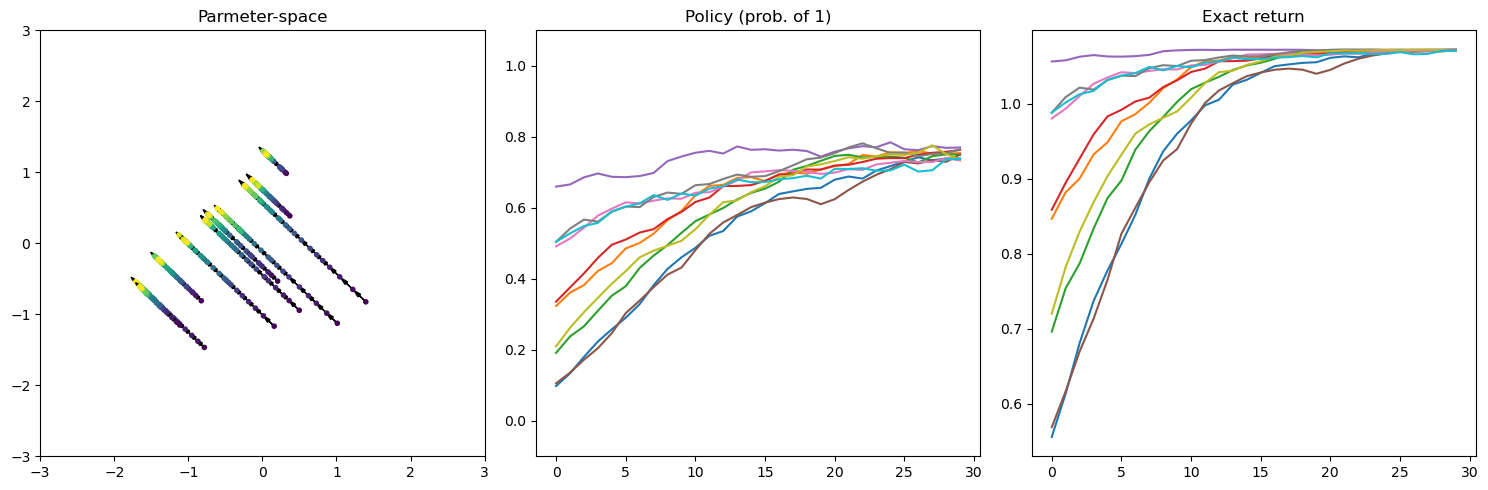

In [33]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
policyClass = plt.Circle((0, 0), plim, color='r',fill=False)
ax[0].add_patch(policyClass)
for trace in traces:
    plot_params_traj(trace,ax[0])
    plot_policy_traj(trace,ax[1],trainer)
    plot_return(trace,ax[2])
ax[0].set_title('Parmeter-space')
ax[1].set_title('Policy (prob. of 1)')
ax[2].set_title('Exact return')

fig.tight_layout()
plt.show()